Due to the not perfectly synchronized measurement and different measurement rate of EIT data and the distance of the ultrasonic sensor, the data must be synchronized afterwards.
As the EIT data cannot be easily interpolated in time, the measured distance values of the ultrasonic sensor are interpolated to the existing time stamps of the EIT measurements. Linear interpolation is used.
A distance value then exists for each measured EIT data point and its associated time stamp.

# Real Data Processing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from util import load_data, plot_mesh_permarray, convert_timestamp, get_fps
import os
import shutil
from sciopy import convert_fulldir_doteit_to_npz
from tqdm import tqdm
from datetime import datetime

**Sciospec**

In [10]:
data_set = 7

path = f"../data/#{data_set}/"
os.chdir(path)

eit_traget = "doteit_npz/"
os.mkdir(eit_traget)

In [11]:
convert_fulldir_doteit_to_npz(glob("eit_raw/*/*/")[0], eit_traget)

In [12]:
skip = 14  # data set: #6, #7
skip = 5  # data set: #1,..., #6
n_el = 32

for ele in tqdm(glob(eit_traget + "*.npz")):
    tmp_eit = np.load(ele, allow_pickle=True)

    els = np.arange(1, n_el + 1)
    mat = np.zeros((n_el, n_el), dtype=complex)

    for i1, i2 in zip(els, np.roll(els, -(skip + 1))):
        mat[i1 - 1, :n_el] = tmp_eit[f"{i1}_{i2}"][:n_el]

    np.savez(
        ele,
        eit=mat,
        eit_time=convert_timestamp(tmp_eit["date_time"].tolist()),
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12220/12220 [00:42<00:00, 289.22it/s]


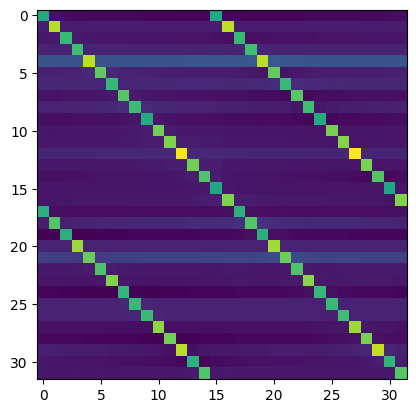

In [13]:
plt.imshow(np.abs(mat))
plt.show()

**Time sync**

In [14]:
master_time = list()
EIT = list()
for ele in np.sort(glob("doteit_npz/*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    master_time.append(tmp["eit_time"])
    EIT.append(tmp["eit"])
EIT = np.array(EIT)
master_time = np.array(master_time)

ard_time = list()
ard_d = list()
for ele in np.sort(glob("arduino_samples/*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    ard_time.append(tmp["timestamp"])
    ard_d.append(tmp["d"])
ard_d = np.array(ard_d)
ard_time = np.array(ard_time)

In [15]:
get_fps(master_time)
get_fps(ard_time)
assert len(ard_d) == len(ard_time), "Arduino time and distance values are not the same."
assert len(EIT) == len(master_time), "EIT time and distance values are not the same."

Mean fps of 35.01
Mean fps of 28.44


In [16]:
print("start:", convert_timestamp(max(ard_time)), convert_timestamp(max(master_time)))
print("start:", convert_timestamp(min(ard_time)), convert_timestamp(min(master_time)))

start: 2024.10.24. 09:15:12.962295 2024.10.24. 09:17:01.923000
start: 2024.10.24. 09:09:25.699230 2024.10.24. 09:11:12.832000


In [17]:
assert max(ard_time) >= max(
    master_time
), "Arduino time index range has to include master time range."

AssertionError: Arduino time index range has to include master time range.

In [18]:
if max(ard_time) <= max(master_time):
    print("Crop the data")
    # crop master time to arduino range
    crop_idx = np.searchsorted(master_time, max(ard_time), side="right")
    master_time = master_time[: crop_idx - 1]
    EIT = EIT[: crop_idx - 1]
    print(f"{EIT.shape=},{master_time.shape=},{ard_time.shape=}")
else:
    print("No cropping is applied")

Crop the data
EIT.shape=(8405, 32, 32),master_time.shape=(8405,),ard_time.shape=(9874,)


In [19]:
print(master_time.shape)
print(ard_time.shape)

(8405,)
(9874,)


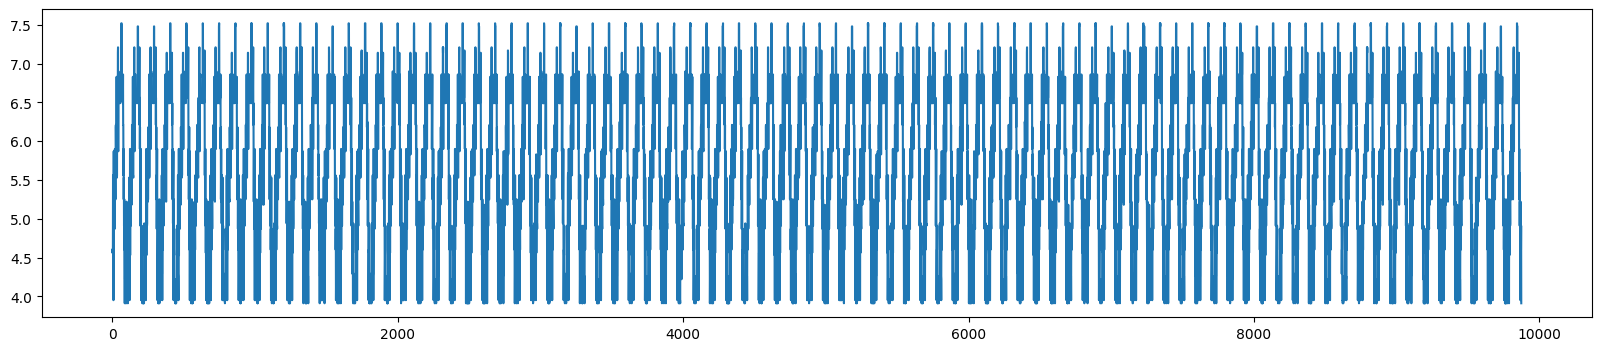

In [20]:
plt.figure(figsize=(20, 4))
plt.plot(ard_d)
plt.show()

In [21]:
def scale_to_01(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

In [22]:
# invert
ard_d_scld_crr = 1 - scale_to_01(ard_d)

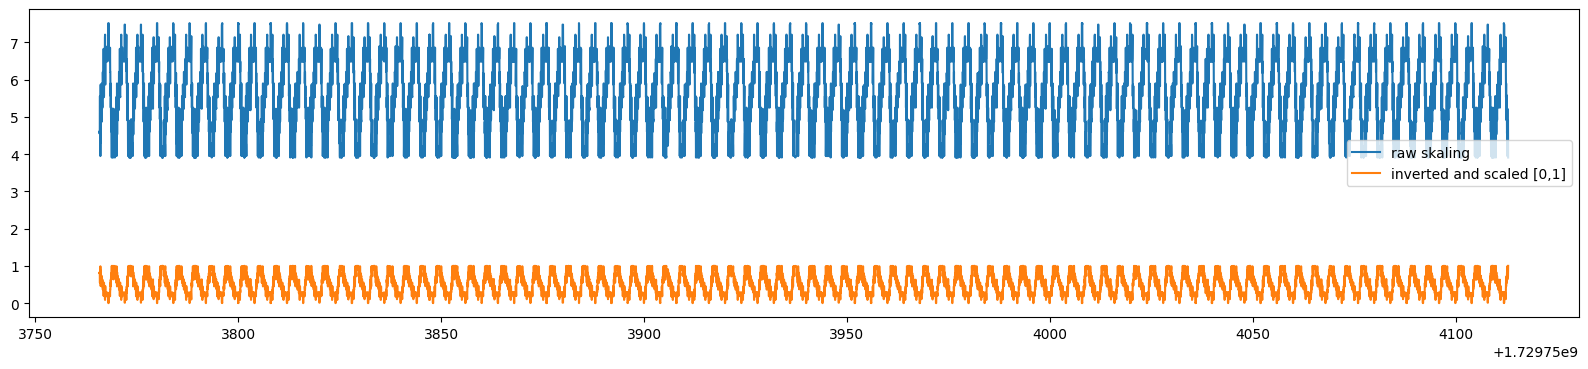

In [23]:
plt.figure(figsize=(20, 4))
plt.plot(ard_time, ard_d, label="raw skaling")
plt.plot(ard_time, ard_d_scld_crr, label="inverted and scaled [0,1]")
plt.legend()
plt.show()

In [24]:
from scipy.signal import savgol_filter

In [25]:
ard_filtered = savgol_filter(ard_d_scld_crr, 51, 2)

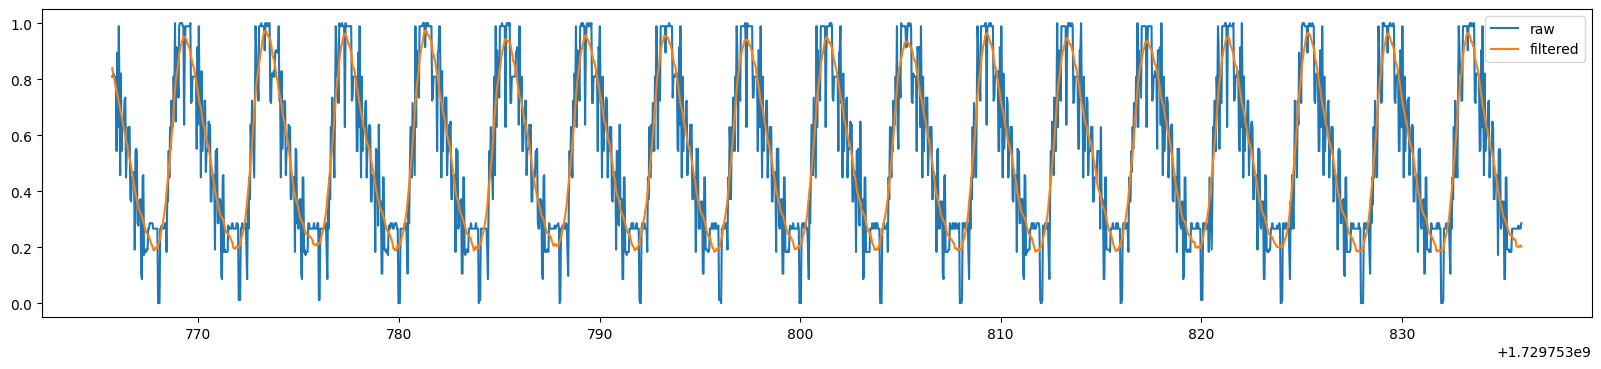

In [26]:
d_inx = 0
u_idx = 2000

plt.figure(figsize=(20, 4))
plt.plot(ard_time[d_inx:u_idx], ard_d_scld_crr[d_inx:u_idx], label="raw")
plt.plot(
    ard_time[d_inx:u_idx], ard_filtered[d_inx:u_idx], label="filtered"
)  # high frequency noise removed
plt.legend()
plt.show()

In [27]:
from scipy.interpolate import interp1d

In [28]:
ard_int_lin = interp1d(ard_time, ard_filtered, kind="linear", fill_value="extrapolate")
data_ard_mapped_lin = ard_int_lin(master_time)

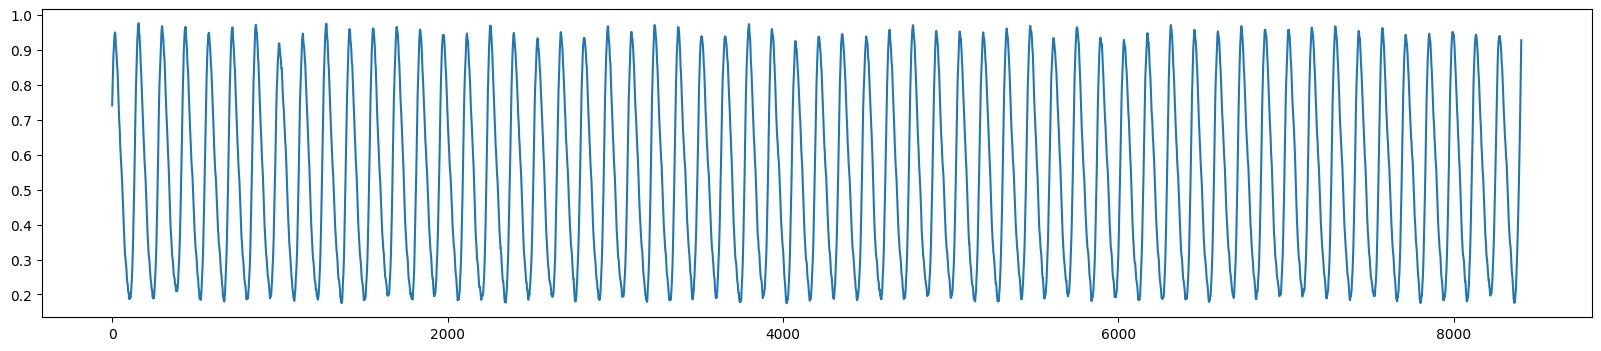

In [29]:
plt.figure(figsize=(20, 4))
plt.plot(data_ard_mapped_lin)
plt.show()

In [30]:
import pyeit.mesh as mesh
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from sciopy import plot_mesh


def scale_array(arr, min_value=0.2, max_value=0.5):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    scaled_arr = (arr - arr_min) / (arr_max - arr_min) * (
        max_value - min_value
    ) + min_value
    return scaled_arr

In [31]:
data_ard_mapped_lin = scale_array(data_ard_mapped_lin, min_value=0.2, max_value=0.5)

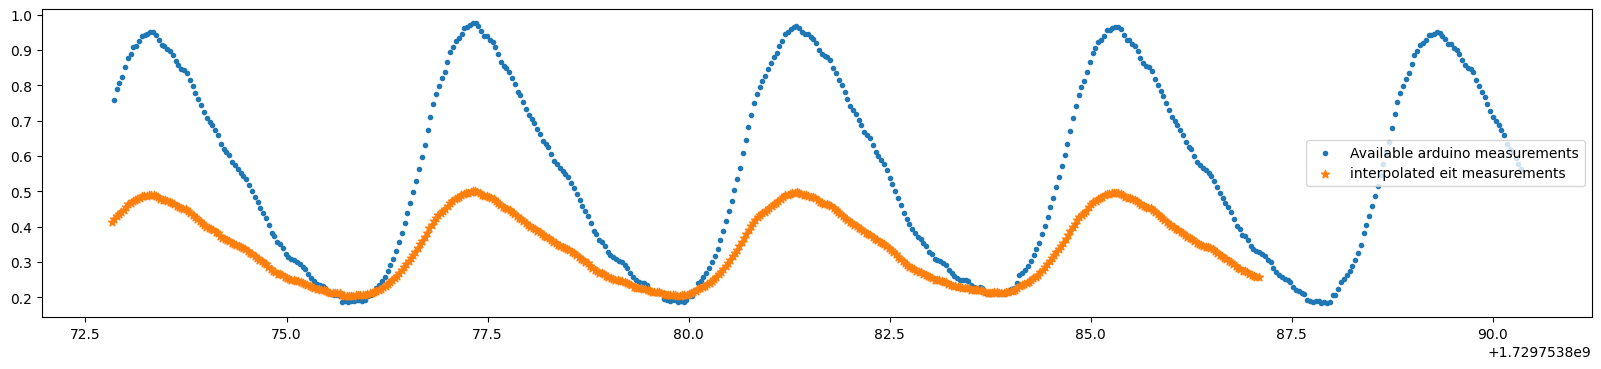

In [32]:
d_inx = 0
u_idx = 500

m_idx = np.searchsorted(ard_time, min(master_time), side="left")
plt.figure(figsize=(20, 4))
plt.scatter(
    ard_time[m_idx + d_inx : m_idx + u_idx],
    ard_filtered[m_idx + d_inx : m_idx + u_idx],
    marker=".",
    label="Available arduino measurements",
)
plt.scatter(
    master_time[d_inx:u_idx],
    data_ard_mapped_lin[d_inx:u_idx],
    marker="*",
    label="interpolated eit measurements",
)
plt.legend()
plt.show()

In [33]:
assert len(master_time) == len(data_ard_mapped_lin)

mesh_obj = mesh.create(n_el, h0=0.05)

os.mkdir("DATA")
for k in range(len(master_time)):
    anomaly = PyEITAnomaly_Circle(center=[0, 0], r=data_ard_mapped_lin[k], perm=10.0)
    mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
    np.savez(
        "DATA/sample_{0:06d}.npz".format(k),
        timestamp=master_time[k],
        eit=EIT[k],
        perm_arr=mesh_new.perm_array,
        d=data_ard_mapped_lin[k],
    )

In [34]:
len(os.listdir("DATA/"))

8405

In [35]:
if os.path.exists("doteit_npz/"):
    shutil.rmtree("doteit_npz/")

## Engineering of loading routine

In [36]:
os.chdir("../../notebooks/")

In [37]:
print(data_set)

7


In [66]:
data_set = 7

In [67]:
EIT, perm_array, D, T = load_data(data_set, info=False)

In [68]:
print(EIT.shape, perm_array.shape, D.shape, T.shape)

(8405, 32, 32) (8405, 2840) (8405,) (8405,)


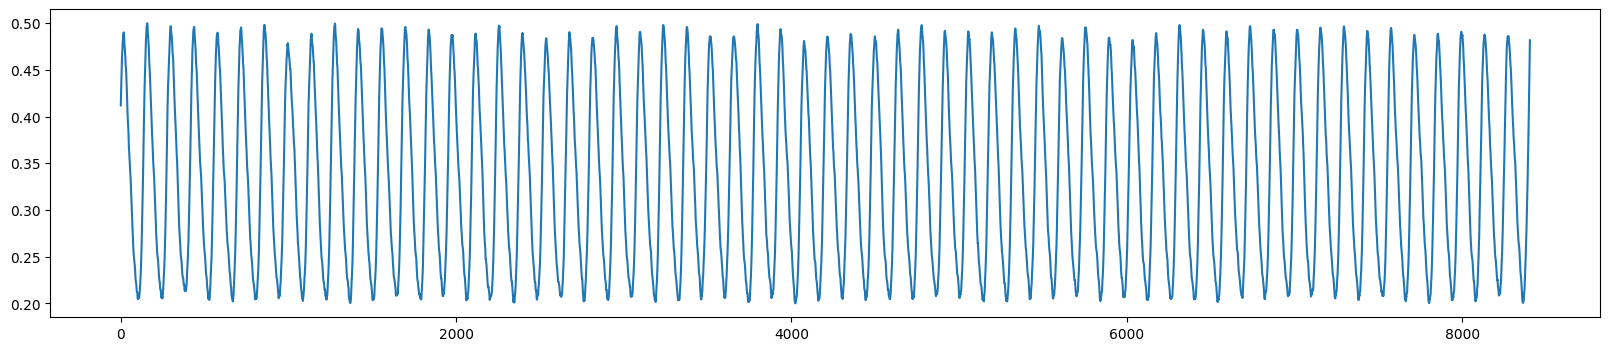

In [69]:
plt.figure(figsize=(20, 4))
plt.plot(D)
plt.show()

In [70]:
from sklearn.decomposition import PCA

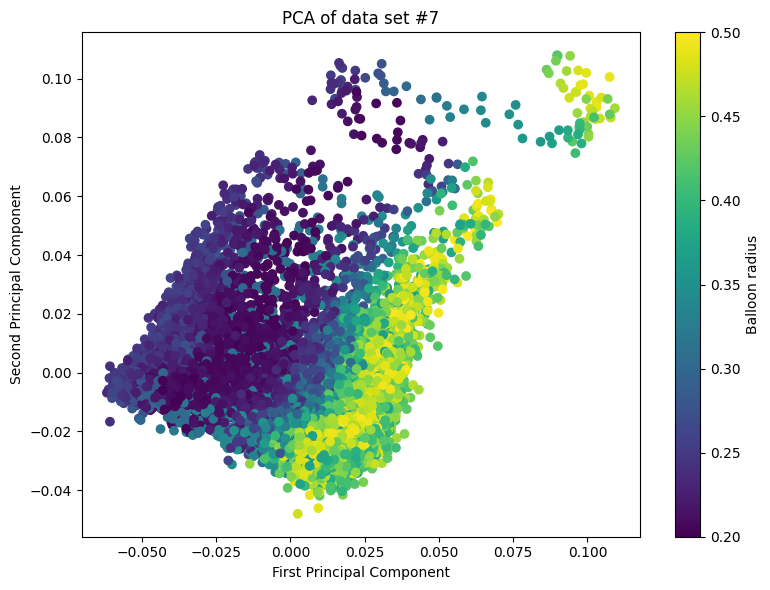

In [71]:
data_flat = EIT.reshape(EIT.shape[0], -1)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_flat)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=D, cmap="viridis")
plt.colorbar(label="Balloon radius")
plt.title(f"PCA of data set #{data_set}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.tight_layout()
plt.savefig(f"../data/#{data_set}/PCA.png")
plt.show()

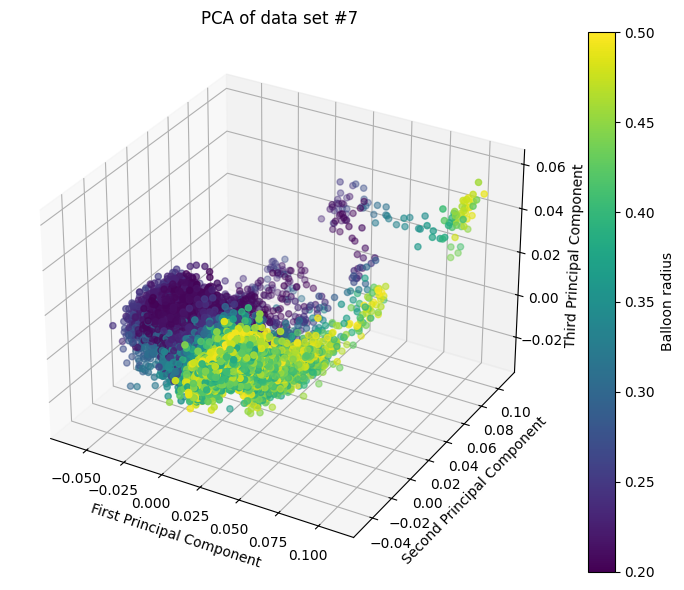

In [72]:
data_flat = EIT.reshape(EIT.shape[0], -1)
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_flat)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=D, cmap="viridis", marker="o"
)
color_bar = fig.colorbar(scatter, ax=ax, label="Balloon radius")
ax.set_title(f"PCA of data set #{data_set}")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
plt.tight_layout()
# plt.savefig(f"../data/#{data_set}/PCA_3D.png")
plt.show()

_archive_